---

## **SFT and DPO Training Pipeline with Unsloth**

This notebook demonstrates:
1. Fine-tuning a Llama-3.2-1B model using Supervised Fine-Tuning (SFT) with Unsloth
2. Evaluating the SFT model against the base model
3. Performing DPO training on the SFT model
4. Evaluating the DPO model against the base model

## Setup
Create a directory for logs and install the necessary packages.

In [1]:
# Create logs directory
!mkdir -p ./outputs/logs

# Start log
!echo "=== STARTING OPTIMIZED SFT AND DPO RUN ===" > ./outputs/logs/training.log

In [ ]:
!pip install ipykernel==6.29.5
!pip install unsloth==2025.4.3
!pip install unsloth-zoo==2025.4.2
!pip install torch==2.7.0+cu121 --index-url https://download.pytorch.org/whl/cu121
!pip install gdown==5.2.0
!pip install huggingface_hub==0.30.2
!pip install wandb==0.19.9  # Optional
!pip install bitsandbytes==0.45.5
!pip install transformers==4.51.3

In [4]:
# Import libraries
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import time
start_time = time.time()

import os
import random
import json
import numpy as np
from collections import defaultdict

try:
    from unsloth.chat_templates import get_chat_template
    from unsloth import FastLanguageModel, is_bfloat16_supported
    from trl import SFTTrainer, DPOTrainer
    from peft import PeftModel
    from datasets import load_dataset
    from transformers import (
        AutoTokenizer, 
        TrainingArguments, 
        TextStreamer,
        AutoModelForCausalLM,
    )
    print("✅ [CHECKPOINT] Imports successful")
except ImportError as e:
    print(f"❌ ImportError: {e}")
    raise

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ [CHECKPOINT] Imports successful


In [5]:
# Check CUDA
print("CUDA available:", torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if torch.cuda.is_available():
    print("GPU Info:")
    print(f"- Device count: {torch.cuda.device_count()}")
    print(f"- Current device: {torch.cuda.current_device()}")
    print(f"- Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Using device: cuda
GPU Info:
- Device count: 1
- Current device: 0
- Device name: NVIDIA GeForce RTX 3090


In [6]:
# Seed for reproducibility
def set_seed(seed=1):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1)
print("✅ [CHECKPOINT] Seed set")

✅ [CHECKPOINT] Seed set


## Load Model
Load model utilizing Unsloth's optimized loading.

In [7]:
print("Loading model - this may take a moment...")
model_load_start = time.time()

max_seq_length = 2048
dtype = None
load_in_4bit = True

try:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=load_in_4bit,
        dtype=dtype,
    )
    print(f"✅ [CHECKPOINT] Model loaded in {time.time() - model_load_start:.2f}s")
    print("Model config:", model.config)
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    raise

Loading model - this may take a moment...
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

✅ [CHECKPOINT] Model loaded in 106.70s
Model config: LlamaConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm

## Setup PEFT/LoRA
Configure model for Parameter-Efficient Fine-Tuning using LoRA.

In [8]:
peft_start = time.time()
model = FastLanguageModel.get_peft_model(
    model,
    r=32,
    lora_alpha=64,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    use_rslora=True,
    use_gradient_checkpointing=True
)
print(f"✅ [CHECKPOINT] PEFT model created in {time.time() - peft_start:.2f}s")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.4.3 patched 16 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


✅ [CHECKPOINT] PEFT model created in 2.37s


## Prepare Dataset
Prepare the Alpaca dataset for fine-tuning.

In [9]:

# Prepare dataset formatting function
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]
    texts = []
    
    for instruction, input_text, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input_text)
        if random.random() < 0.2:
            ws = random.choice([" ", "\n", "\n\n", "\n \n", "  "])
            text = text + ws + output + EOS_TOKEN
        else:   
            text = text + '\n' + output + EOS_TOKEN
        texts.append(text)
    return {"text": texts} 

In [10]:
# Load and process the dataset
dataset_start = time.time()
print("Loading dataset...")

try:
    dataset = load_dataset("yahma/alpaca-cleaned", split="train[:30000]")
    dataset = dataset.map(formatting_prompts_func, batched=True)
    print(f"✅ [CHECKPOINT] Dataset loaded and processed in {time.time() - dataset_start:.2f}s with {len(dataset)} examples")
    
    # Display a sample
    print("\nSample from dataset:")
    print(dataset[0]["text"][:500] + "...")


    print(f"Filtered dataset size: {len(dataset)} (original had ~52k)")
except Exception as e:
    print(f"❌ Failed to load/process dataset: {e}")
    raise

Loading dataset...


README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


alpaca_data_cleaned.json:   0%|          | 0.00/44.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51760 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

✅ [CHECKPOINT] Dataset loaded and processed in 8.43s with 30000 examples

Sample from dataset:
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Give three tips for staying healthy.

### Input:


### Response:
1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help pr...
Filtered dataset size: 30000 (original had ~52k)


In [11]:
print(dataset[4040]["text"][:1000])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Output which of the 3 figures is biggest.

### Input:
Figure 1 is 27 cm, Figure 2 is 15 cm, and Figure 3 is 10 cm

### Response:
Based on the given input, Figure 1 is the biggest with a size of 27 cm.<|end_of_text|>


## Configure Training
Set up the training configuration using SFTTrainer.

In [12]:
# Configure the SFT Trainer
output_dir = "./outputs"

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    dataset_num_proc=12,
    packing=True,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=16,
        warmup_steps=100,
        num_train_epochs=2.0,
        learning_rate=1e-5,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=50,
        logging_first_step=True,
        optim="adamw_8bit",
        weight_decay=0.02,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir=output_dir,
        report_to="none",
        save_strategy="steps",
        save_steps=100,
        gradient_checkpointing=True,
        max_grad_norm=0.3,
        dataloader_num_workers=8,
        dataloader_pin_memory=True,
    ),
)

print("✅ [MAXIMUM PERFORMANCE CONFIG] Trainer configured for optimal quality training")

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/30000 [00:00<?, ? examples/s]

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!
✅ [MAXIMUM PERFORMANCE CONFIG] Trainer configured for optimal quality training


## Train the Model
Start the training process.

In [13]:
# Train the model
train_start = time.time()

try:
    trainer_stats = trainer.train()
    print(f"✅ [CHECKPOINT] Training completed in {time.time() - train_start:.2f}s")
    print(f"Training stats: {trainer_stats}")
except Exception as e:
    print(f"❌ Training failed: {e}")
    raise

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 30,000 | Num Epochs = 2 | Total steps = 1,874
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 16 x 1) = 32
 "-____-"     Trainable parameters = 6,815,744/1,000,000,000 (0.68% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.951700
50,1.841900
100,1.322200
150,1.239400
200,1.228900
250,1.217400
300,1.208300
350,1.198300
400,1.205500
450,1.189900


✅ [CHECKPOINT] Training completed in 4668.25s
Training stats: TrainOutput(global_step=1874, training_loss=1.2012812039768175, metrics={'train_runtime': 4666.9355, 'train_samples_per_second': 12.856, 'train_steps_per_second': 0.402, 'total_flos': 9.26512933243945e+16, 'train_loss': 1.2012812039768175})


## Save the Model
Save the trained LoRA adapter.

In [14]:
# Save adapter
save_start = time.time()
sft_adapter_path = "./outputs/sft_lora_adapter"

try:
    model.save_pretrained(
        sft_adapter_path,
        save_adapter=True,
        save_config=True
    )
    print(f"✅ [CHECKPOINT] SFT model adapter saved in {time.time() - save_start:.2f}s")
except Exception as e:
    print(f"❌ Failed to save model: {e}")
    raise

✅ [CHECKPOINT] SFT model adapter saved in 0.49s


## Test the Fine-Tuned Model
We can test our fine-tuned model with a sample prompt.

In [15]:
# Test the fine-tuned model
print("Testing fine-tuned model with a sample prompt...")

try:
    # Load the adapter onto a fresh model instance
    test_model, test_tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=load_in_4bit
    )
    
    # Load the PEFT adapter
    test_model = PeftModel.from_pretrained(test_model, sft_adapter_path)
    
    # Create a text streamer for nice output
    streamer = TextStreamer(test_tokenizer, skip_prompt=True)
    
    # Sample prompt
    test_prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain the concept of fine-tuning in machine learning.

### Response:
"""
    
    print("\nPrompt:\n", test_prompt)
    print("\nGenerated Response:")
    
    # Generate response
    inputs = test_tokenizer(test_prompt, return_tensors="pt").to(device)
    
    output = test_model.generate(
        **inputs,
        max_new_tokens=256,
        use_cache=True,
        streamer=streamer
    )
except Exception as e:
    print(f"❌ Testing failed: {e}")

Testing fine-tuned model with a sample prompt...
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Prompt:
 Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain the concept of fine-tuning in machine learning.

### Response:


Generated Response:
Fine-tuning is a technique used in machine learning to improve the performance of a model by adjusting its parameters to fit the specific task at hand. It involves adjusting the parameters of the model, such as the weights and biases, to make it more effective

## Set up Evaluation
Now we'll set up a comprehensive evaluation comparing our fine-tuned model against the base model using a judge model.

In [76]:
# Set up evaluation
eval_start = time.time()

print("Loading models for evaluation...")

def load_base_model():
    print("Loading base model")
    try:
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
            max_seq_length=1024,
            load_in_4bit=True,
            dtype=None,
        )
        return model, tokenizer
    except Exception as e:
        print(f"❌ Failed to load base model: {e}")
        raise

def load_sft_model():
    print("Loading SFT model")
    try:
        base_model, tokenizer = FastLanguageModel.from_pretrained(
            model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
            max_seq_length=1024,
            load_in_4bit=True,
            dtype=None,
        )
        peft_model = PeftModel.from_pretrained(base_model, sft_adapter_path)
        return peft_model, tokenizer
    except Exception as e:
        print(f"❌ Failed to load SFT model: {e}")
        raise

def load_judge_model():
    print("Loading judge model")
    try:
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name="unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit",
            max_seq_length=2048,
            load_in_4bit=True,
            dtype=None,
        )
        return model, tokenizer
    except Exception as e:
        print(f"❌ Failed to load judge model: {e}")
        raise

try:
    base_model, base_tokenizer = load_base_model()
    sft_model, sft_tokenizer = load_sft_model()
    judge_model, judge_tokenizer = load_judge_model()
    print("✅ [CHECKPOINT] Evaluation models loaded")
except Exception as e:
    print(f"❌ Failed to load evaluation models: {e}")
    raise

Loading models for evaluation...
Loading base model
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Loading SFT model
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Lo

## Run Comparative Evaluation
Let's run a comparative evaluation between the base model and our fine-tuned model.

In [17]:
import time
import torch
from datasets import load_dataset

# Define helper functions for evaluation
def format_prompt(instruction):
    return f"""Below is an instruction that describes a task. Write a response that completes the request. You will be judged on the following criteria:
    1. **Objectivity**: How objective and formal the tone is. 
    2. **Instruction Following**: How well the response directly addresses the instruction's requirements.
    3. **Specificity**: How specific and long the response is.
    4. **Clarity**: How readable and coherent the response is, with no extraneous characters.
    5. **Accuracy**: Factual correctness and logical consistency.
    6. **Helpfulness**: Practicality and usefulness of the response.

### Instruction:
{instruction}

### Response:"""

def generate_response(model, tokenizer, prompt):
    inputs = tokenizer(
        prompt, 
        return_tensors="pt", 
        truncation=True, 
        max_length=2048,
    ).to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
            top_k=50,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
        )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove the prompt from the response
    return full_response[len(prompt):].strip()

In [18]:
def get_judgment(instruction, sft_response, base_response):
    prompt = f"""You are an impartial judge evaluating two responses to an instruction. Score based on the following criteria, ignoring the order of the responses, prioritizing these metrics:

1. **Objectivity**: How objective and formal the tone is.
2. **Instruction Following**: How well the response directly addresses the instruction's requirements.
3. **Specificity**: How specific and long the response is.
4. **Clarity**: How readable and coherent the response is, with no extraneous characters.
5. **Accuracy**: Factual correctness and logical consistency.
6. **Helpfulness**: Practicality and usefulness of the response.


**Special Rule**: If the First Response (SFT Model) is empty, irrelevant, or fails to provide any meaningful answer, score the Second Response (Base Model) as significantly better unless it is also empty or irrelevant.

Return ONLY a single number:
1 = First response (SFT Model) is significantly better
2 = Second response (Base Model) is significantly better
0 = Both are comparable (similar quality or minor differences)

Instruction:
{instruction}

First Response (SFT Model):
{sft_response}

Second Response (Base Model):
{base_response}

Judgment (1/2/0):"""
    
    inputs = judge_tokenizer(
        prompt,
        return_tensors="pt",
        max_length=2048,
        truncation=True
    ).to("cuda")
    
    with torch.no_grad():
        outputs = judge_model.generate(
            **inputs,
            max_new_tokens=3,
            temperature=0.0,
            do_sample=False,
        )
    
    verdict = judge_tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract the last valid digit from the response
    verdict_digits = [c for c in verdict.strip() if c.isdigit()]
    return int(verdict_digits[-1]) if verdict_digits else 0

# Load evaluation dataset
print("Loading evaluation dataset...")
MAX_SAMPLES = 500

try:
    eval_dataset = load_dataset("tatsu-lab/alpaca_eval", "alpaca_eval", trust_remote_code=True)["eval"]
    eval_dataset = eval_dataset.shuffle(seed=420).select(range(min(len(eval_dataset), MAX_SAMPLES)))
    print(f"Loaded evaluation dataset with {len(eval_dataset)} examples")
except Exception as e:
    print(f"❌ Failed to load evaluation dataset: {e}")
    raise

Loading evaluation dataset...


README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

alpaca_eval.py:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

alpaca_eval.json:   0%|          | 0.00/621k [00:00<?, ?B/s]

/root/.cache/huggingface/hub/datasets--tatsu-lab--alpaca_eval/snapshots/2edc6fad8be6b14ea7230aabfd08188da6b8b814/alpaca_eval.json


Generating eval split: 0 examples [00:00, ? examples/s]

Loaded evaluation dataset with 500 examples


In [ ]:
# Run evaluation
print(f"Running evaluation on {len(eval_dataset)} examples...")
eval_start = time.time()
results = []
cnt = 0
empty_check = 0 
for i, example in enumerate(eval_dataset):
    try:
        
        print(f"\nExample {i+1}/{len(eval_dataset)}")
        if cnt%10==0: print(f"Evaluating: {example['instruction'][:100]}...")
        
        prompt = format_prompt(example["instruction"])
        base_response = generate_response(base_model, base_tokenizer, prompt)
        sft_response = generate_response(sft_model, sft_tokenizer, prompt)

        if cnt%10==0:
            print("\nBase Model Response:")
            print(base_response)
            print("\nSFT Model Response:")
            print(sft_response)
        
        # Check for empty or non-meaningful responses
        base_empty = not base_response.strip() or len(base_response.strip()) < 5 or base_response.strip().lower() in ["n/a", "none", "no response"]
        sft_empty = not sft_response.strip() or len(sft_response.strip()) < 5 or sft_response.strip().lower() in ["n/a", "none", "no response"]

        if base_empty:
            empty_check += 1
        if base_empty and not sft_empty:
            verdict = 2
            print("Base response empty or non-meaningful - verdict: 2 (SFT wins)")
        elif sft_empty and not base_empty:
            verdict = 1
            print("SFT response empty or non-meaningful - verdict: 1 (Base wins)")
        elif base_empty and sft_empty:
            verdict = 0
            print("Both responses empty or non-meaningful - verdict: 0 (tie)")
        elif base_response.strip() == sft_response.strip():
            verdict = 0
            print("Responses identical - verdict: 0 (tie)")
        else:
            verdict = get_judgment(example["instruction"], sft_response, base_response)  # Fixed argument order
            print(f"\nVerdict: {verdict} ({['Tie', 'Base wins', 'SFT wins'][verdict]})")  # Fixed verdict labels
        
        results.append({
            "instruction": example["instruction"],
            "sft_response": sft_response,
            "base_response": base_response,
            "verdict": verdict
        })
        print(sum(1 for r in results if r["verdict"] == 2), empty_check)
        cnt += 1

    except Exception as e:
        print(f"Error processing example {i+1}: {e}")
        continue

# Calculate and display summary statistics
total = len(results)
if total > 0:
    base_wins = sum(1 for r in results if r["verdict"] == 1)
    sft_wins = sum(1 for r in results if r["verdict"] == 2)
    ties = sum(1 for r in results if r["verdict"] == 0)
    
    print("\n=== Evaluation Summary ===")
    print(f"Total examples evaluated: {total}")
    print(f"Base Model wins: {base_wins} ({base_wins/total:.1%})")
    print(f"SFT Model wins: {sft_wins} ({sft_wins/total:.1%})")
    print(f"Ties: {ties} ({ties/total:.1%})")
    print('empty response:' ,empty_check)

print(f"\n✅ Evaluation completed in {time.time() - eval_start:.2f}s")

## Analyze SFT Results
We can analyze and save the evaluation results.

In [20]:
# Calculate statistics
verdicts = [r["verdict"] for r in results]  # Changed from sft_results to results to match variable name
sft_stats = {
    "base_wins": sum(1 for v in verdicts if v == 1),  # Using sum() to match evaluation code style
    "sft_wins": sum(1 for v in verdicts if v == 2),
    "ties": sum(1 for v in verdicts if v == 0),
    "total": len(verdicts),
    "sft_win_rate": sum(1 for v in verdicts if v == 2) / len(verdicts) if verdicts else 0,
}

# Print summary statistics
print("\n=== SFT Evaluation Summary ===")
print(f"Total examples evaluated: {sft_stats['total']}")
print(f"Base Model wins: {sft_stats['base_wins']} ({sft_stats['base_wins']/sft_stats['total']:.1%})")
print(f"SFT Model wins: {sft_stats['sft_wins']} ({sft_stats['sft_wins']/sft_stats['total']:.1%})")
print(f"Ties: {sft_stats['ties']} ({sft_stats['ties']/sft_stats['total']:.1%})")

# Save results

sft_output_file = "./outputs/alpacaeval_sft_results.json"

with open(sft_output_file, "w") as f:
    json.dump({
        "statistics": sft_stats,
        "results": results,
        "config": {
            "base_model": "unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
            "sft_adapter": "/output/sft_lora_adapter",
            "judge_model": "unsloth/Llama-3.2-8B-Instruct-unsloth-bnb-4bit",
            "num_samples": len(results)
        }
    }, f, indent=2)

print(f"✅ [CHECKPOINT] DPO results saved to {sft_output_file}")


=== SFT Evaluation Summary ===
Total examples evaluated: 500
Base Model wins: 127 (25.4%)
SFT Model wins: 309 (61.8%)
Ties: 64 (12.8%)
✅ [CHECKPOINT] DPO results saved to ./outputs/alpacaeval_sft_results.json


## Prepare for DPO Training
Prepare for Direct Preference Optimization (DPO) training using the SFT model as our starting point.

In [22]:
# Load the SFT model as our policy model
print("Loading SFT model for DPO training...")

try:
    dpo_model, dpo_tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=True,
        dtype=None,
    )
    
    dpo_model = PeftModel.from_pretrained(dpo_model, sft_adapter_path)
    
    ref_model, _ = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=True,
        dtype=None,
    )
    
    print("✅ [CHECKPOINT] DPO models loaded")
except Exception as e:
    print(f"❌ Failed to load DPO models: {e}")
    raise

Loading SFT model for DPO training...
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ [CHECKPOINT] DPO models loaded


In [25]:



# Load preference dataset for DPO
print("Loading preference dataset for DPO...")
try:
    NUM_EXAMPLES = 4000
    
    # Load dataset
    dataset = load_dataset("Intel/orca_dpo_pairs")
    
    # Use specified number of examples for training
    dpo_dataset = dataset["train"].select(range(min(NUM_EXAMPLES, len(dataset["train"]))))
    
    # Format the dataset for DPO and perform validation
    def format_dpo_example(example):
        if not example["system"]:
            system = "You are a helpful assistant."
        else:
            system = example["system"]
            
        return {
            "prompt": system + '\n' +example['question'],
            "chosen": example["chosen"],
            "rejected": example["rejected"],
        }

            
    def filter_valid_examples(example):
        if not example["chosen"].strip() or not example["rejected"].strip():
            return False
        if len(example["question"]) > 2000:  # ~512 tokens
            return False
        if np.abs(len(example['rejected']) - len(example['chosen'])) > 400:
            return False
        return True
    
    # Format dataset
    dpo_dataset = dpo_dataset.map(format_dpo_example)
    dpo_dataset = dpo_dataset.filter(filter_valid_examples)
    
    print(f"Loaded DPO dataset with {len(dpo_dataset)} examples (from target of {NUM_EXAMPLES})")
    
    # Display a sample
    print("\nSample from DPO dataset:")
    print("Prompt:", dpo_dataset[0]["prompt"][:500] + "..." if len(dpo_dataset[0]["prompt"]) > 500 else dpo_dataset[0]["prompt"])
    print("Chosen response:", dpo_dataset[0]["chosen"][:500] + "..." if len(dpo_dataset[0]["chosen"]) > 500 else dpo_dataset[0]["chosen"])
    print("Rejected response:", dpo_dataset[0]["rejected"][:500] + "..." if len(dpo_dataset[0]["rejected"]) > 500 else dpo_dataset[0]["rejected"])
    
    # Dataset statistics
    prompt_lengths = [len(example["prompt"]) for example in dpo_dataset]
    chosen_lengths = [len(example["chosen"]) for example in dpo_dataset]
    rejected_lengths = [len(example["rejected"]) for example in dpo_dataset]
    
    print("\nDataset Statistics:")
    print(f"Average prompt length: {sum(prompt_lengths)/len(prompt_lengths):.1f} chars")
    print(f"Average chosen response length: {sum(chosen_lengths)/len(chosen_lengths):.1f} chars")
    print(f"Average rejected response length: {sum(rejected_lengths)/len(rejected_lengths):.1f} chars")
    
    # Pre-tokenize the dataset for DPOTrainer
    def tokenize_dataset(example):
        # Tokenize prompt
        prompt_tokens = dpo_tokenizer(example["prompt"], truncation=True, max_length=256, padding=False)
        
        # Tokenize chosen and rejected responses
        chosen_tokens = dpo_tokenizer(example["chosen"], truncation=True, max_length=max_seq_length, padding=False)
        rejected_tokens = dpo_tokenizer(example["rejected"], truncation=True, max_length=max_seq_length, padding=False)
        
        return {
            "prompt": example["prompt"],
            "chosen": example["chosen"],
            "rejected": example["rejected"],
            "input_ids": prompt_tokens["input_ids"],
            "attention_mask": prompt_tokens["attention_mask"],
            "chosen_input_ids": chosen_tokens["input_ids"],
            "chosen_attention_mask": chosen_tokens["attention_mask"],
            "rejected_input_ids": rejected_tokens["input_ids"],
            "rejected_attention_mask": rejected_tokens["attention_mask"],
        }
        
    tokenized_dataset = dpo_dataset.map(
        tokenize_dataset,
        batched=False,
        num_proc=4,
    )
    
    print("✅ Dataset tokenized successfully")
    
except Exception as e:
    print(f"❌ Failed to load/process DPO dataset: {e}")
    raise

Loading preference dataset for DPO...


README.md:   0%|          | 0.00/196 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


orca_rlhf.jsonl:   0%|          | 0.00/36.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12859 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Loaded DPO dataset with 1709 examples (from target of 4000)

Sample from DPO dataset:
Prompt: You are an AI assistant. You will be given a task. You must generate a detailed and long answer.
Generate an approximately fifteen-word sentence that describes all this data: Midsummer House eatType restaurant; Midsummer House food Chinese; Midsummer House priceRange moderate; Midsummer House customer rating 3 out of 5; Midsummer House near All Bar One
Chosen response: Midsummer House is a moderately priced Chinese restaurant with a 3/5 customer rating, located near All Bar One.
Rejected response:  Sure! Here's a sentence that describes all the data you provided:

"Midsummer House is a moderately priced Chinese restaurant with a customer rating of 3 out of 5, located near All Bar One, offering a variety of delicious dishes."

Dataset Statistics:
Average prompt length: 585.5 chars
Average chosen response length: 665.2 chars
Average rejected response length: 764.5 chars


Map (num_proc=4):   0%|          | 0/1709 [00:00<?, ? examples/s]

✅ Dataset tokenized successfully


In [26]:
dpo_dataset[1]

{'system': 'You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old.',
 'question': 'What happens next in this paragraph?\n\nShe then rubs a needle on a cotton ball then pushing it onto a pencil and wrapping thread around it. She then holds up a box of a product and then pouring several liquids into a bowl. she\nChoose your answer from: A. adds saucepan and shakes up the product in a grinder. B. pinches the thread to style a cigarette, and then walks away. C. then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. D. begins to style her hair and cuts it several times before parting the ends of it to show the hairstyle she has created.',
 'chosen': 'C. She then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. In this option, she is continuing the process of using the needle, pencil, and thread, which is most relate

In [27]:

prompt = format_prompt( eval_dataset['instruction'][10])
print(prompt)

import torch
import torch.nn.functional as F


def show_topk_multiple_steps(model, tokenizer, prompt, k=10, steps=3):
    model.eval()
    input_ids = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)["input_ids"].to(model.device)

    for step in range(steps):
        with torch.no_grad():
            outputs = model(input_ids=input_ids)
            logits = outputs.logits  # (B, T, V)

        next_token_logits = logits[0, -1, :]  # 마지막 토큰 위치의 logits
        probs = F.softmax(next_token_logits, dim=-1)
        topk_probs, topk_indices = torch.topk(probs, k)

        print(f"\nStep {step+1}:")
        for i in range(k):
            token = tokenizer.decode([topk_indices[i].item()])
            prob = topk_probs[i].item()
            print(f"{i+1}: '{token}'  (P={prob:.4f})")

        # 다음 토큰을 샘플링 or argmax로 선택 (여기선 argmax로)
        next_token = topk_indices[0].unsqueeze(0).unsqueeze(0)  # shape: (1,1)
        input_ids = torch.cat([input_ids, next_token], dim=1)


show_topk_multiple_steps(sft_model, tokenizer, prompt, k=10)

Below is an instruction that describes a task. Write a response that completes the request. You will be judged on the following criteria:
    1. **Objectivity**: How objective and formal the tone is. 
    2. **Instruction Following**: How well the response directly addresses the instruction's requirements.
    3. **Specificity**: How specific and long the response is.
    4. **Clarity**: How readable and coherent the response is, with no extraneous characters.
    5. **Accuracy**: Factual correctness and logical consistency.
    6. **Helpfulness**: Practicality and usefulness of the response.

### Instruction:
What color is the sky

### Response:

Step 1:
1: ' '  (P=0.3691)
2: ' The'  (P=0.2871)
3: ' 
'  (P=0.1055)
4: ' Blue'  (P=0.0388)
5: ' **'  (P=0.0267)
6: ' 

'  (P=0.0267)
7: '  '  (P=0.0111)
8: ' It'  (P=0.0077)
9: ' A'  (P=0.0067)
10: ' Green'  (P=0.0067)

Step 2:
1: ' The'  (P=0.6055)
2: ' Blue'  (P=0.1348)
3: ' **'  (P=0.0342)
4: ' Green'  (P=0.0300)
5: ' It'  (P=0.0161)
6: '

In [240]:
print(tokenized_dataset['prompt'][27])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are an AI assistant. You will be given a task. You must generate a detailed and long answer.

### Input:
I want to test the ability of students to read a passage and answer questions about it. Could you please come up with a good question for the passage "On the night of December 25, 1991, at 7:32 p.m. Moscow time, after Gorbachev left the Kremlin, the Soviet flag was lowered for the last time, and the Russian tricolor was raised in its place, symbolically marking the end of the Soviet Union. The next day, December 26, 1991, the Council of Republics, the upper chamber of the Union's Supreme Soviet, issued a formal Declaration recognizing that the Soviet Union had ceased to exist as a state and subject of international law, and voted both itself and the Soviet Union out of existence (the other chamber of the S

In [125]:
import torch
import gc

def clear_gpu_memory():
    gc.collect()                      # CPU 메모리 회수
    torch.cuda.empty_cache()         # GPU 캐시 비우기
    torch.cuda.ipc_collect()         # CUDA IPC 핸들 정리 (multi process용)
    torch.cuda.synchronize()         # GPU 동기화 (안정적 종료)

    # 추가로 GPU 상태 확인하고 싶다면
    print(torch.cuda.memory_summary())
# 모델 삭제
clear_gpu_memory()
del dpo_eval_model



|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 5            |        cudaMalloc retries: 23        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  18818 MiB |  23328 MiB | 583072 GiB | 583054 GiB |
|       from large pool |  18014 MiB |  22482 MiB | 514296 GiB | 514278 GiB |
|       from small pool |    803 MiB |    952 MiB |  68776 GiB |  68775 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  18818 MiB |  23328 MiB | 583072 GiB | 583054 GiB |
|       from large pool |  18014 MiB |  22482 MiB | 514296 GiB |

In [ ]:
# Load the SFT model as our policy model
print("Loading SFT model for DPO training...")

try:
    dpo_model, dpo_tokenizer = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=True,
        dtype=None,
    )
    
    dpo_model = PeftModel.from_pretrained(dpo_model, sft_adapter_path, is_trainable = True)
    
    ref_model, _ = FastLanguageModel.from_pretrained(
        model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
        max_seq_length=max_seq_length,
        load_in_4bit=True,
        dtype=None,
    )
    ref_model = PeftModel.from_pretrained(ref_model, sft_adapter_path, is_trainable = False)
    

    print("✅ [CHECKPOINT] DPO models loaded")
except Exception as e:
    print(f"❌ Failed to load DPO models: {e}")
    raise

Loading SFT model for DPO training...
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ [CHECKPOINT] DPO models loaded


## Configure DPO Training
Set up the DPO trainer with appropriate parameters.

In [ ]:
from typing import Any, Callable, Literal, Optional, Union
class BetaDPOTrainer(DPOTrainer):
    def __init__(self, *args, alpha: float = 0.8, momentum: float = 0.9,**kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.momentum = momentum
        self.M0 = 0.0
        self.step = 0

        self.var = 0.0
        self.Mi_history = []
        self.M0_history = []
        self.sigma_history = []

    
    def get_batch_loss_metrics(
        self,
        model,
        batch: dict[str, Union[list, torch.LongTensor]],
        train_eval: Literal["train", "eval"] = "train",
    ):
        """Compute the DPO loss and other metrics for the given batch of inputs for train or test."""

        metrics = {}

        model_output = self.concatenated_forward(model, batch)

        # if ref_chosen_logps and ref_rejected_logps in batch use them, otherwise use the reference model
        if "ref_chosen_logps" in batch and "ref_rejected_logps" in batch:
            ref_chosen_logps = batch["ref_chosen_logps"]
            ref_rejected_logps = batch["ref_rejected_logps"]
        else:
            ref_chosen_logps, ref_rejected_logps = self.compute_ref_log_probs(batch)


        Mi = self.beta*(model_output["chosen_logps"] - ref_chosen_logps) - self.beta*(model_output["rejected_logps"] - ref_rejected_logps)
        delta = Mi - self.M0
        beta_batch = (1 + self.alpha*delta) * self.beta
        original_beta = self.beta
        

        self.M0 = self.momentum*self.M0 + (1-self.momentum)*Mi
        delta = Mi - self.M0
        self.var = self.momentum * self.var + (1 - self.momentum) * (delta ** 2)
        sigma = self.var ** 0.5
        
        try:
            self.beta = beta_batch.item()
            #print('beta:',self.beta,'\n')
            losses, chosen_rewards, rejected_rewards = self.dpo_loss(
            model_output["chosen_logps"], model_output["rejected_logps"], ref_chosen_logps, ref_rejected_logps
            )
        finally:
            self.beta = original_beta
        reward_accuracies = (chosen_rewards > rejected_rewards).float()

        if self.args.rpo_alpha is not None:
            losses = losses + self.args.rpo_alpha * model_output["nll_loss"]  # RPO loss from V3 of the paper

        if self.use_weighting:
            losses = losses * model_output["policy_weights"]

        if self.aux_loss_enabled:
            losses = losses + self.aux_loss_coef * model_output["aux_loss"]
        prefix = "eval_" if train_eval == "eval" else ""
        metrics[f"{prefix}rewards/chosen"] = self.accelerator.gather_for_metrics(chosen_rewards).mean().item()
        metrics[f"{prefix}rewards/rejected"] = self.accelerator.gather_for_metrics(rejected_rewards).mean().item()
        metrics[f"{prefix}rewards/accuracies"] = self.accelerator.gather_for_metrics(reward_accuracies).mean().item()
        metrics[f"{prefix}rewards/margins"] = (
            self.accelerator.gather_for_metrics(chosen_rewards - rejected_rewards).mean().item()
        )
        metrics[f"{prefix}logps/chosen"] = (
            self.accelerator.gather_for_metrics(model_output["chosen_logps"]).detach().mean().item()
        )
        metrics[f"{prefix}logps/rejected"] = (
            self.accelerator.gather_for_metrics(model_output["rejected_logps"]).detach().mean().item()
        )
        metrics[f"{prefix}logits/chosen"] = (
            self.accelerator.gather_for_metrics(model_output["mean_chosen_logits"]).detach().mean().item()
        )
        metrics[f"{prefix}logits/rejected"] = (
            self.accelerator.gather_for_metrics(model_output["mean_rejected_logits"]).detach().mean().item()
        )
        if self.args.rpo_alpha is not None:
            metrics[f"{prefix}nll_loss"] = (
                self.accelerator.gather_for_metrics(model_output["nll_loss"]).detach().mean().item()
            )
        if self.aux_loss_enabled:
            metrics[f"{prefix}aux_loss"] = (
                self.accelerator.gather_for_metrics(model_output["aux_loss"]).detach().mean().item()
            )

        self.step += 1  
        if self.step > 1:
            self.Mi_history.append(Mi.item())
            self.M0_history.append(self.M0.item())
            self.sigma_history.append(sigma.item())
            if torch.abs(Mi -self.M0) > 1.5*sigma:
                losses = (losses * 0.0).mean()


            #print('M0:',self.M0,'\n', 'sigma:',sigma,'\n','Mi:', Mi,'\n', 'steps:', self.step)   
            #print('loss:',losses)
        
        return losses.mean(), metrics


In [ ]:
# Configure DPO trainer
dpo_output_dir = "./outputs/beta_dpo_model"
# Define DPO training arguments
dpo_training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    num_train_epochs=1.0,
    learning_rate=1e-7,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=100,
    optim="adamw_torch",
    weight_decay=0.01,
    lr_scheduler_type="cosine_with_restarts",
    seed=3407,
    output_dir=dpo_output_dir,
    report_to="none",
    save_strategy="steps",
    save_steps=100,
    gradient_checkpointing=True,
    max_grad_norm=2.0,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    group_by_length=True,
)


dpo_trainer = BetaDPOTrainer(
    model=dpo_model,
    ref_model=ref_model,
    args=dpo_training_args,
    beta=0.1,
    train_dataset=tokenized_dataset,
    tokenizer=dpo_tokenizer,
    max_length=max_seq_length,
    max_prompt_length=512,
    generate_during_eval=True,
)
print("✅ [CHECKPOINT] DPO trainer configured with optimized hyperparameters")

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


✅ [CHECKPOINT] DPO trainer configured with optimized hyperparameters


## Run DPO Training


In [ ]:
# Train with DPO
print("Starting DPO training...")
dpo_train_start = time.time()

try:
    dpo_trainer.train()
    print(f"✅ [CHECKPOINT] DPO training completed in {time.time() - dpo_train_start:.2f}s")
except Exception as e:
    print(f"❌ DPO training failed: {e}")
    raise

Starting DPO training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,709 | Num Epochs = 1 | Total steps = 854
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 6,815,744/1,000,000,000 (0.68% trained)


Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
100,0.647900,0.004455,-0.015641,0.580000,0.020096,-208.598618,-214.400970,3.128184,2.950348,0,0,0,0
200,0.609400,-0.008416,-0.107542,0.860000,0.099126,-217.434692,-214.145935,3.113617,2.962363,No Log,No Log,No Log,No Log
300,0.566900,-0.022968,-0.203112,0.950000,0.180144,-239.521561,-222.568359,3.130072,2.901041,No Log,No Log,No Log,No Log
400,0.482900,-0.032602,-0.301385,0.960000,0.268782,-208.493088,-211.050247,3.078838,2.940737,No Log,No Log,No Log,No Log
500,0.484000,-0.049949,-0.387770,0.970000,0.337820,-247.732498,-237.055954,3.158370,2.942632,No Log,No Log,No Log,No Log
600,0.450800,-0.052504,-0.451739,0.980000,0.399235,-230.214264,-219.088043,3.087592,2.974669,No Log,No Log,No Log,No Log
700,0.470600,-0.071975,-0.504307,0.990000,0.432332,-235.959183,-238.452484,3.235324,2.968685,No Log,No Log,No Log,No Log
800,0.473000,-0.078361,-0.498345,1.000000,0.419984,-223.672180,-223.617630,3.207715,2.932344,No Log,No Log,No Log,No Log


✅ [CHECKPOINT] DPO training completed in 399.65s


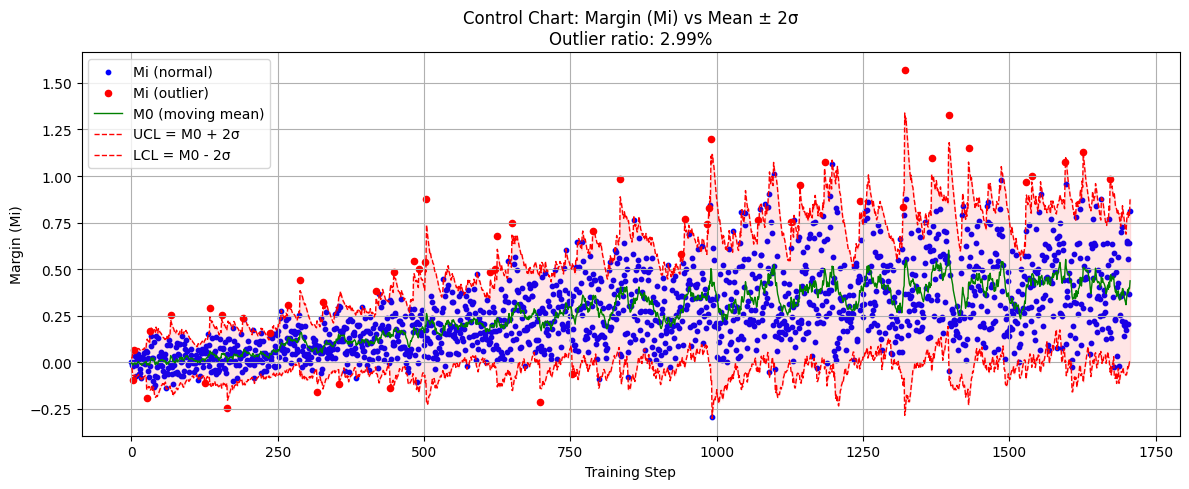

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# trainer 인스턴스
trainer = dpo_trainer  # 실제 트레이너 이름 사용

steps = np.arange(len(trainer.Mi_history))
Mi_vals = np.array(trainer.Mi_history)
M0_vals = np.array(trainer.M0_history)
sigma_vals = np.array(trainer.sigma_history)

UCL = M0_vals + 2 * sigma_vals
LCL = M0_vals - 2 * sigma_vals

# 이상치 판단
is_outlier = (Mi_vals > UCL) | (Mi_vals < LCL)
outlier_ratio = 100 * np.sum(is_outlier) / len(Mi_vals)

# 시각화
plt.figure(figsize=(12, 5))

# Mi 점 찍기 (이상치: 빨간색, 정상치: 파란색)
plt.scatter(steps[~is_outlier], Mi_vals[~is_outlier], color="blue", s=10, label="Mi (normal)")
plt.scatter(steps[is_outlier], Mi_vals[is_outlier], color="red", s=20, label="Mi (outlier)")

# 평균 및 경계선
plt.plot(steps, M0_vals, label="M0 (moving mean)", color="green", linewidth=1)
plt.plot(steps, UCL, label="UCL = M0 + 2σ", color="red", linestyle="--", linewidth=1)
plt.plot(steps, LCL, label="LCL = M0 - 2σ", color="red", linestyle="--", linewidth=1)
plt.fill_between(steps, LCL, UCL, color='red', alpha=0.1)

# 제목 + 이상치 비율 출력
plt.title(f"Control Chart: Margin (Mi) vs Mean ± 2σ\nOutlier ratio: {outlier_ratio:.2f}%")
plt.xlabel("Training Step")
plt.ylabel("Margin (Mi)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Save DPO Model
Save the DPO-trained model adapter.

In [ ]:
# Save DPO adapter
betadpo_adapter_path = "./outputs/betadpo_lora_adapter"

try:
    dpo_trainer.model.save_pretrained(
        betadpo_adapter_path,
        save_adapter=True,
        save_config=True
    )
    print(f"✅ [CHECKPOINT] betaDPO model adapter saved to {betadpo_adapter_path}")
except Exception as e:
    print(f"❌ Failed to save DPO model: {e}")
    raise

✅ [CHECKPOINT] betaDPO model adapter saved to ./outputs/betadpo_lora_adapter


In [ ]:
import torch
from peft import PeftModel
from unsloth import FastLanguageModel

# Clear GPU cache first
torch.cuda.empty_cache()

# 1. Load base model (4-bit quantized)
model, dpo_eval_tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
    max_seq_length=1024,  # Reduce if OOM (original: 2048)
    dtype=torch.float16,  # Use float16 for efficiency
    load_in_4bit=True,
)

# 2. Define a custom device_map to offload some layers to CPU
device_map = {
    "model.embed_tokens": 0,  # GPU
    "model.layers.0": 0,
    "model.layers.1": 0,
    # ... (assign more layers to GPU if possible)
    "model.norm": "cpu",  # Offload norm layer to CPU
    "lm_head": "cpu",     # Offload final layer to CPU
}

# 3. Load DPO adapter with manual offloading
try:
    dpo_eval_model = PeftModel.from_pretrained(
        model,
        betadpo_adapter_path,
        device_map=device_map,
    )
    print("✅ [SUCCESS] DPO model loaded with CPU offloading!")
except Exception as e:
    print(f"❌ [ERROR] Failed to load DPO adapter: {e}")
    raise

==((====))==  Unsloth 2025.4.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.684 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ [SUCCESS] DPO model loaded with CPU offloading!


In [ ]:
# Run DPO evaluation
print(f"Running evaluation on {len(eval_dataset)} examples...")
eval_start = time.time()
results = []
empty_check = 0
cnt = 0

for i, example in enumerate(eval_dataset):
    try:
        print(f"\nExample {i+1}/{len(eval_dataset)}")
        #if cnt%10==0: 
        print(f"Evaluating: {example['instruction'][:100]}...")
        
        prompt = format_prompt(example["instruction"])
        base_response = generate_response(base_model, base_tokenizer, prompt)
        dpo_response = generate_response(dpo_eval_model, dpo_eval_tokenizer, prompt)
        
        if cnt%10==0: 
            print("\nDPO Model Response:")
            print(dpo_response)
            print("\nBase Model Response:")
            print(base_response)
        
        
        
        # Check for empty or non-meaningful responses
        base_empty = not base_response.strip() or len(base_response.strip()) < 5 or base_response.strip().lower() in ["n/a", "none", "no response"]
        dpo_empty = not dpo_response.strip() or len(dpo_response.strip()) < 5 or dpo_response.strip().lower() in ["n/a", "none", "no response"]
        if dpo_empty:
            empty_check += 1
        if base_empty and not dpo_empty:
            verdict = 2
            print("Base response empty or non-meaningful - verdict: 2 (DPO wins)")
        elif dpo_empty and not base_empty:
            verdict = 1
            print("DPO response empty or non-meaningful - verdict: 1 (Base wins)")
        elif base_empty and dpo_empty:
            verdict = 0
            print("Both responses empty or non-meaningful - verdict: 0 (tie)")
        elif base_response.strip() == dpo_response.strip():
            verdict = 0
            print("Responses identical - verdict: 0 (tie)")
        else:
            verdict = get_judgment(example["instruction"], dpo_response, base_response)
            print(f"\nVerdict: {verdict} ({['Tie', 'Base wins', 'DPO wins'][verdict]})")
        
        results.append({
            "instruction": example["instruction"],
            "base_response": base_response,
            "dpo_response": dpo_response,
            "verdict": verdict
        })
        print('dpo:',sum(1 for r in results if r["verdict"] == 2), 'empty:', empty_check)
        cnt += 1
    except Exception as e:
        print(f"Error processing example {i+1}: {e}")
        continue

# Calculate and display summary statistics
total = len(results)
if total > 0:
    base_wins = sum(1 for r in results if r["verdict"] == 1)
    dpo_wins = sum(1 for r in results if r["verdict"] == 2)
    ties = sum(1 for r in results if r["verdict"] == 0)
'''   
    print("\n=== Evaluationquet Summary ===")
    print(f"Total examples evaluated: {total}")
    print(f"Base Model wins: {base_wins} ({base_wins/total:.1%})")
    print(f"DPO Model wins: {dpo_wins} ({dpo_wins/total:.1%})")
    print(f"Ties: {ties} ({ties/total:.1%})")
'''

# Calculate statistics
verdicts = [r["verdict"] for r in results]
dpo_stats = {
    "base_wins": sum(1 for v in verdicts if v == 1),
    "dpo_wins": sum(1 for v in verdicts if v == 2),
    "ties": sum(1 for v in verdicts if v == 0),
    "total": len(verdicts),
    "dpo_win_rate": sum(1 for v in verdicts if v == 2) / len(verdicts) if verdicts else 0,
}

# Print summary statistics
print("\n=== DPO Evaluation Summary ===")
print(f"Total examples evaluated: {dpo_stats['total']}")
print(f"Base Model wins: {dpo_stats['base_wins']} ({dpo_stats['base_wins']/dpo_stats['total']:.1%})")
print(f"DPO Model wins: {dpo_stats['dpo_wins']} ({dpo_stats['dpo_wins']/dpo_stats['total']:.1%})")
print(f"Ties: {dpo_stats['ties']} ({dpo_stats['ties']/dpo_stats['total']:.1%})")

print(f"\n✅ Evaluation completed in {time.time() - eval_start:.2f}s")

In [ ]:
# Save DPO results
dpo_output_file = "./outputs/alpacaeval_betadpo_results.json"

with open(dpo_output_file, "w") as f:
    json.dump({
        "statistics": dpo_stats,
        "results": results,
        "config": {
            "base_model": "unsloth/Llama-3.2-1B-unsloth-bnb-4bit",
            "dpo_adapter": "/output/dpo_lora_adapter",
            "judge_model": "unsloth/Llama-3.2-8B-Instruct-unsloth-bnb-4bit",
            "num_samples": len(results)
        }
    }, f, indent=2)

print(f"✅ [CHECKPOINT] DPO results saved to {dpo_output_file}")

✅ [CHECKPOINT] DPO results saved to ./outputs/alpacaeval_betadpo_results.json


## Final Summary
Print a final summary of the entire pipeline.

Compare SFT and DPO Results

In [ ]:
print("\n=== Model Comparison Summary ===")
print(f"SFT Win Rate: {sft_stats['sft_win_rate']:.1%}")
print(f"DPO Win Rate: {dpo_stats['dpo_win_rate']:.1%}")
print(f"\nSFT Performance: Base Wins: {sft_stats['base_wins']} | SFT Wins: {sft_stats['sft_wins']} | Ties: {sft_stats['ties']}")
print(f"DPO Performance: Base Wins: {dpo_stats['base_wins']} | DPO Wins: {dpo_stats['dpo_wins']} | Ties: {dpo_stats['ties']}")

# Calculate improvement
improvement = (dpo_stats['dpo_win_rate'] - sft_stats['sft_win_rate']) * 100
print(f"\nDPO improvement over SFT: {improvement:.1f} percentage points")


=== Model Comparison Summary ===
SFT Win Rate: 61.8%
DPO Win Rate: 67.6%

SFT Performance: Base Wins: 127 | SFT Wins: 309 | Ties: 64
DPO Performance: Base Wins: 111 | DPO Wins: 338 | Ties: 51

DPO improvement over SFT: 5.8 percentage points


In [ ]:
print("\n=== FINAL SUMMARY ===")
print(f"SFT Win Rate: {sft_stats['sft_win_rate']:.1%}")
print(f"DPO Win Rate: {dpo_stats['dpo_win_rate']:.1%}")
print(f"DPO Improvement over SFT: {improvement:.1f} percentage points")
print(f"\nFULL PIPELINE COMPLETED SUCCESSFULLY in {time.time() - start_time:.2f}s")


=== FINAL SUMMARY ===
SFT Win Rate: 61.8%
DPO Win Rate: 67.6%
DPO Improvement over SFT: 5.8 percentage points

FULL PIPELINE COMPLETED SUCCESSFULLY in 14414.69s


## huggingface upload



In [4]:
dpo_eval_model = dpo_eval_model.merge_and_unload()

hf_user_name = "E0oom"
repo_name = "Llama-3.2-1B-betadpo"
model_name = f"{hf_user_name}/{repo_name}"
commit_m = ""


dpo_eval_model.push_to_hub(
    model_name,
    commit_message = commit_m,
)
dpo_eval_tokenizer.push_to_hub(
    repo_name,
    commit_message = commit_m,
)

NameError: name 'dpo_eval_model' is not defined